# CamK Stats and Plots

### Package Imports

In [3]:
import mysql.connector
from mysql.connector import errorcode
from ephyspy import mysql_manager 
import configparser
import pandas as pd
from IPython.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

### mySQL Connection info

In [4]:
config = configparser.ConfigParser()
config.read('config.ini')
DB_NAME = config.get('connections', 'DB_NAME')
USER_NAME = config.get('connections', 'DB_USER')
PWD = config.get('connections', 'DB_PWD')
HOST_NAME = config.get('connections','DB_HOST')
PORT = config.get('connections', 'DB_PORT')

### Download raw data from database

In [5]:
sql = "SELECT * FROM camk_steps"
cnx = mysql.connector.connect(user = USER_NAME, password = PWD, host = HOST_NAME, database = DB_NAME, port = PORT)
cursor = cnx.cursor(buffered = True)
mysql_manager.locate_database(cursor, DB_NAME)
cursor.execute(sql)
search = cursor.fetchall()
df = pd.DataFrame(search)
df.columns = ['id','filename','strain', 'ch','conc_nmda','charge', 'charge_step', 'cm', 'holding',
          'rinput','ica','ih','iahp','h_50','h_40', 'h_30', 'h_20', 'h_10','h_0','d_10','d_20','d_30','d_40','d_50','d_60']
display(HTML(df.head().to_html()))
df.to_csv('200310_camk_steps_raw.csv')

Data base haleygee_olive  is active.


,id,filename,strain,ch,conc_nmda,charge,charge_step,cm,holding,rinput,ica,ih,iahp,h_50,h_40,h_30,h_20,h_10,h_0,d_10,d_20,d_30,d_40,d_50,d_60
0,1,2019_08_08_0008.abf,cam_cre,0,0,-23.1596,-10,0.431786,0.440125,113.0940,-389.453,1.39703,10.3271,-386.578,-322.462,-250.4580,-173.0080,-88.4217,0.440125,88.8257,187.1260,274.5350,378.3080,475.5900,576.6960
1,2,2019_08_08_0008.abf,cam_cre,2,0,-208.0580,-10,0.048064,-2.584230,198.2290,-1622.390,14.68510,90.8691,-347.400,-270.516,-192.8120,-127.1450,-50.4468,-2.584230,56.0437,115.7430,277.5360,423.4790,557.1490,685.0560
2,3,2019_08_08_0013.abf,cam_cre,0,0,-65.0025,-10,0.153840,-0.333862,349.0860,-215.909,-4.53065,22.1277,-215.041,-156.712,-100.3630,-61.8317,-28.6462,-0.333862,19.6417,34.9628,47.5439,58.3728,67.3523,73.1146
3,4,2019_08_08_0015.abf,cam_cre,2,0,-353.9510,-10,0.028252,-6.403820,91.1701,-5141.790,31.76700,16.9043,-669.770,-528.354,-370.9080,-235.9010,-109.6850,-6.403820,88.6084,206.2740,303.3510,609.4840,896.1940,1326.0200
4,5,2019_08_08_0018.abf,cam_cre,0,0,-275.8690,-10,0.036249,12.844900,226.0200,-501.824,-2.13925,37.7271,-231.740,-183.107,-71.1884,-90.1141,-44.2438,12.844900,41.1291,89.5490,197.9560,267.4730,341.0110,433.7690


### Add Row for ITail

In [6]:
df['itail'] = np.nan
for i in range(0,len(df.strain)):
    ica = df.ica[i]
    iahp = df.iahp[i]
    df.loc[i, 'itail'] = max([abs(ica), abs(iahp)])
    i = i + 1

### Clean the data

In [56]:
df = df[df.holding >= -500]
df = df[df.rinput <= 500]

# Cm Calculation was wrong from raw analysis
df.cm = df.charge/df.charge_step

### Get Descriptive Stats

In [57]:
df_mean = df.groupby('strain').mean()
df_ste = df.groupby('strain').sem()
df_std = df.groupby('strain').std()

df_mean = df_mean.reset_index()
df_ste = df_ste.reset_index()
df_std = df_std.reset_index()

labels = ['cm','holding','rinput','itail','ih','iahp', 'ica']

df_desc = pd.DataFrame({ 'measure':[], 'strain': [], 'mean':[], 'ste':[], 'std':[]})
for label in labels:
    row1 = {'measure': label, 'strain': df_mean['strain'][0], 'mean': df_mean[label][0], 'ste':df_ste[label][0], 'std':df_std[label][0]} 
    row2 = {'measure': label, 'strain': df_mean['strain'][1], 'mean': df_mean[label][1], 'ste':df_ste[label][1], 'std':df_std[label][1]} 
    row3 = {'measure': label, 'strain': df_mean['strain'][2], 'mean': df_mean[label][2], 'ste':df_ste[label][2], 'std':df_std[label][2]} 
    row4 = {'measure': label, 'strain': df_mean['strain'][3], 'mean': df_mean[label][3], 'ste':df_ste[label][3], 'std':df_std[label][3]} 
    df_desc = df_desc.append([row1,row2,row3,row4], ignore_index = True)                            
display(HTML(df_desc.to_html()))
df_desc.to_csv('camk_intrinsic_desc.csv')

,measure,strain,mean,ste,std
0,cm,cam_cre,17.217382,2.082845,13.336718
1,cm,cam_flox,12.562399,2.422900,17.804603
2,cm,cam_ko,16.596739,2.571161,15.639764
3,cm,wt,9.665883,2.307410,8.633537
4,holding,cam_cre,-0.451242,0.641321,4.106459
5,holding,cam_flox,-0.199285,0.342497,2.516826
6,holding,cam_ko,0.220684,0.755090,4.593035
7,holding,wt,-0.248322,0.375116,1.403554
8,rinput,cam_cre,144.167137,11.703302,74.937694
9,rinput,cam_flox,173.788522,11.892579,87.392249


### One-Way Anovas

In [58]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

base = importr('base')
utils = importr('utils')
desc_tools = importr('DescTools')
fsa = importr('FSA')
rcompanion = importr('rcompanion')
mcv = importr('multcompView')
lsmeans = importr('lsmeans')
stats = importr('stats')
dunnett = ro.r['DunnettTest']

def get_anova (dep_var, label, df_anovas):
    """User passes the the dependent variable and measurement label. 
    The function calculates the linear model, summarizes the data, 
    then performs an anova. Output is saved as a .csv spreadsheet in
    the working directory."""
    df_anova = pd.DataFrame()
    ro.globalenv['dep_var'] = dep_var
    lm_x = stats.lm("dep_var ~ strain")
    lm_summary = base.summary(lm_x)
    anova_results = stats.anova(lm_x)
    anova_summary = base.summary(anova_results)
    
    # Parse the chaotic output of lm() and anova() into a pandas dataframe
    df_groups = int(anova_results[0][0])
    df_err = int(anova_results[0][1])
    ss_groups = float(anova_results[1][0])
    ss_err = float(anova_results[1][1])
    ms_groups = float(anova_results[2][0])
    ms_err = float(anova_results[2][1])
    f_stat = float(anova_results[3][0])    
    p_value = float(anova_results[4][0])
    row = {'measure': label, 'df_group': df_groups, 'ss_groups': ss_groups, 
            'ss_err':ss_err, 'ms_groups': ms_groups, 'ms_err': ms_err, 
            'df_err': df_err, 'f_stat': f_stat, 'p_value': p_value}
    df_anova = df_anova.append(row, ignore_index = True)
    df_anova = df_anova[['measure', 'df_group', 'df_err', 'ss_groups',
                       'ss_err', 'ms_groups', 'ms_err','f_stat', 'p_value']]
    df_anovas = df_anovas.append(df_anova)
    return df_anovas

# Cycle through the measurements and perform one way anova on each 
# with strain as the ind. var

cm = ro.vectors.FloatVector(df.cm)
holding = ro.vectors.FloatVector(df.holding)
r_input = ro.vectors.FloatVector(df.rinput)
itail = ro.vectors.FloatVector(df.itail)
ih = ro.vectors.FloatVector(df.ih)
iahp = ro.vectors.FloatVector(df.iahp)
ica = ro.vectors.FloatVector(df.ica)
strain = ro.vectors.FactorVector(df.strain)

ro.globalenv['cm'] = cm
ro.globalenv['holding'] = holding
ro.globalenv['r_input'] = r_input
ro.globalenv['itail'] = itail
ro.globalenv['ih'] = ih
ro.globalenv['iahp'] = iahp
ro.globalenv['ica'] = ica
ro.globalenv['strain'] = strain
measures = [cm,holding,r_input,itail,ih,iahp,ica]



df_anovas = pd.DataFrame()
i = 0
for measure in measures:
    df_anovas = get_anova(measure, labels[i], df_anovas)
    i = i+1
df_anovas.to_csv('intrinsic_one_way_anova.csv', index = True) # Save the dataframe to a csv spreadsheet
display(HTML(df_anovas.to_html())) # Display the results in a table
    

,measure,df_group,df_err,ss_groups,ss_err,ms_groups,ms_err,f_stat,p_value
0,cm,3.0,142.0,9.934017e+02,3.369060e+04,331.133903,237.257760,1.395672,0.246643
0,holding,3.0,142.0,9.022221e+00,1.795309e+03,3.007407,12.643018,0.237871,0.869830
0,rinput,3.0,142.0,2.999095e+04,1.010638e+06,9996.982950,7117.169436,1.404629,0.243975
0,itail,3.0,142.0,2.767329e+06,4.797144e+07,922443.124845,337827.029609,2.730519,0.046181
0,ih,3.0,142.0,9.670305e+03,2.163824e+05,3223.434846,1523.819686,2.115365,0.100937
0,iahp,3.0,142.0,7.811723e+03,2.396245e+05,2603.907569,1687.496361,1.543060,0.206020
0,ica,3.0,142.0,2.767329e+06,4.797144e+07,922443.124845,337827.029609,2.730519,0.046181


### Dunnett Planned Comparisons

In [59]:
def get_dunnett(dep_var, label, df_dunnett):
        """User passes the the dependent variable and measurement label. 
        The function performs planned comparisons using the Dunnett test 
        and summarizes the data. Output is saved as a .csv spreadsheet in
        the working directory."""
        
        df_dun = pd.DataFrame()
        display(HTML('<h4>Dunnett Planned Comparisons: ' + label))
        dunnett_results = dunnett(x = dep_var, g = strain, control = 'wt')
        pairs = base.labels(dunnett_results[0])
        calculations = base.labels(dunnett_results[0][1])
        i = 0
        for pair in pairs[0]:
            groups = pair.split('-')
            row = {'measurement': label,
                   'group1': groups[0],
                   'group2': groups[1],
                   'diff': dunnett_results[0][i],
                   'lwr_ci': dunnett_results[0][i+3],
                   'upr_ci': dunnett_results[0][i+6],
                   'p_val': dunnett_results[0][i+9]}
            df_dun = df_dun.append(row, ignore_index = True)
            i = i + 1
        df_dun = df_dun[['measurement','group1', 'group2', 'diff', 'lwr_ci', 'upr_ci', 'p_val']]
        df_dunnett = df_dunnett.append(df_dun, ignore_index = True)
        display(HTML(df_dun.to_html()))
        return df_dunnett

# Cycle through the measurements and perform Dunnett planned comparisons on 
# each with strain as the ind. var    
df_dunnett = pd.DataFrame()
i = 0
for measure in measures:
    df_dunnett = get_dunnett(measure, labels[i], df_dunnett)
    i = i+1
df_dunnett.to_csv('camk_intrinsic_dunnett.csv', index = True) # Save the dataframe to a csv spreadsheet
display(HTML(df_dunnett.to_html())) # Display the results in a table


,measurement,group1,group2,diff,lwr_ci,upr_ci,p_val
0,cm,cam_cre,wt,7.551499,-3.414216,18.517215,0.221251
1,cm,cam_flox,wt,2.896516,-7.727902,13.520934,0.802416
2,cm,cam_ko,wt,6.930856,-4.184715,18.046428,0.285691


,measurement,group1,group2,diff,lwr_ci,upr_ci,p_val
0,holding,cam_cre,wt,-0.202921,-2.734270,2.328429,0.992134
1,holding,cam_flox,wt,0.049037,-2.403527,2.501601,0.999872
2,holding,cam_ko,wt,0.469006,-2.096937,3.034949,0.923112


,measurement,group1,group2,diff,lwr_ci,upr_ci,p_val
0,rinput,cam_cre,wt,10.758051,-49.301270,70.817372,0.926969
1,rinput,cam_flox,wt,40.379437,-17.810593,98.569466,0.216319
2,rinput,cam_ko,wt,27.062331,-33.817751,87.942412,0.523040


,measurement,group1,group2,diff,lwr_ci,upr_ci,p_val
0,itail,cam_cre,wt,-182.960293,-596.744548,230.823963,0.526697
1,itail,cam_flox,wt,-433.833944,-834.739543,-32.928345,0.031096
2,itail,cam_ko,wt,-299.970946,-719.409909,119.468017,0.198254


,measurement,group1,group2,diff,lwr_ci,upr_ci,p_val
0,ih,cam_cre,wt,-29.549906,-57.340227,-1.759586,0.034869
1,ih,cam_flox,wt,-26.400587,-53.325959,0.524785,0.055467
2,ih,cam_ko,wt,-23.046888,-51.216987,5.123210,0.125515


,measurement,group1,group2,diff,lwr_ci,upr_ci,p_val
0,iahp,cam_cre,wt,17.416901,-11.827867,46.661670,0.317037
1,iahp,cam_flox,wt,23.411127,-4.923425,51.745679,0.120752
2,iahp,cam_ko,wt,10.343728,-19.300694,39.988151,0.678234


,measurement,group1,group2,diff,lwr_ci,upr_ci,p_val
0,ica,cam_cre,wt,-182.960293,-596.744548,230.823963,0.526697
1,ica,cam_flox,wt,-433.833944,-834.739543,-32.928345,0.031096
2,ica,cam_ko,wt,-299.970946,-719.409909,119.468017,0.198254


,measurement,group1,group2,diff,lwr_ci,upr_ci,p_val
0,cm,cam_cre,wt,7.551499,-3.414216,18.517215,0.221251
1,cm,cam_flox,wt,2.896516,-7.727902,13.520934,0.802416
2,cm,cam_ko,wt,6.930856,-4.184715,18.046428,0.285691
3,holding,cam_cre,wt,-0.202921,-2.734270,2.328429,0.992134
4,holding,cam_flox,wt,0.049037,-2.403527,2.501601,0.999872
5,holding,cam_ko,wt,0.469006,-2.096937,3.034949,0.923112
6,rinput,cam_cre,wt,10.758051,-49.301270,70.817372,0.926969
7,rinput,cam_flox,wt,40.379437,-17.810593,98.569466,0.216319
8,rinput,cam_ko,wt,27.062331,-33.817751,87.942412,0.523040
9,itail,cam_cre,wt,-182.960293,-596.744548,230.823963,0.526697


### Plot Descriptive Stats

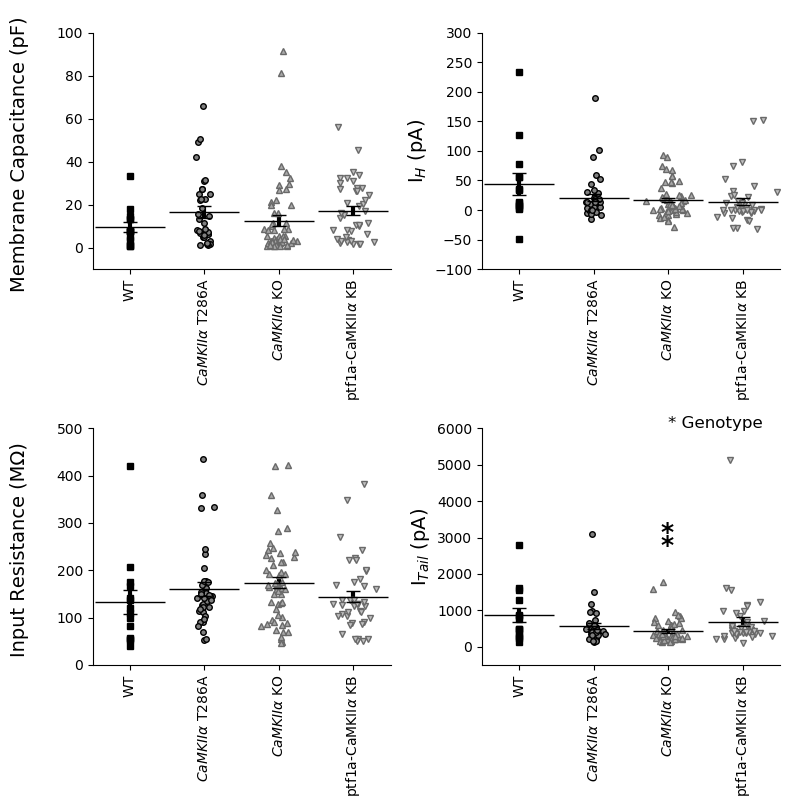

In [117]:
def plot_desc (fig, ax, col, row, y_scatter, y_mean, y_err, y_title, y_min, y_max, me, stars):
    """ Creates a scatter plot of raw data and overlays the mean +/- standard error of the mean."""
    i = 0
    padding = max(y_err)
    for ys in y_scatter:
        for y in ys:
            ax[row][col].plot ((i + i*np.random.randn(1)*.05), y, ls = 'none', marker = markers[i], 
                               markersize = sizes[i], color = colors[i], mec = edges[i])
        i = i + 1
    ax[row][col].plot (x, y_mean, ls = 'none', marker = '_', markersize = 50, color = 'k')
    ax[row][col].errorbar(x, y_mean, y_err, ls = 'none', elinewidth = 3, capsize = 5, color = 'k')
    ax[row][col].set_xlim(-0.5, 3.5)
    if isinstance(y_min, str)  == True or isinstance(y_max, str)  == True:
        y_min, y_max = ax[row][col].get_ylim()
        y_min = y_min - padding
        y_max = y_max + padding
    ax[row][col].set_ylim(y_min, y_max)
    ax[row][col].set_ylabel(y_title, size = 14)
    ax[row][col].tick_params (axis = 'x', labelsize = 10, labelrotation = 90)       
    ax[row][col].spines['top'].set_visible(False)
    ax[row][col].spines['right'].set_visible(False)
    ax[row][col].set_xticklabels(x_labels)
    ax[row][col].annotate(me, xy=(2,y_max), fontsize = 12)
    j = 0
    for star in stars:
        if star == 1:
            ax[row][col].annotate('*', xy = (j-.1, max(y_scatter[j]) + padding*4), fontsize = 18, weight = 'bold')
        elif star == 2:
            ax[row][col].annotate('*', xy = (j-.1, max(y_scatter[j]) + padding*4), fontsize = 18, weight = 'bold')
            ax[row][col].annotate('*', xy = (j-.1, max(y_scatter[j]) + padding*4 + max(y_scatter[j])*0.2), fontsize = 18, weight = 'bold')
        j = j + 1

fig, ax = plt.subplots(2,2, figsize = (8,8), dpi = 100)

x = ['wt', 'cam_ko', 'cam_flox', 'cam_cre']
x_labels = ['WT', r'$CaMKII\alpha$'+' T286A', r'$CaMKII\alpha$' + ' KO', 'ptf1a-CaMKII'+r'$\alpha$' + ' KB']
y_titles = ["Membrane Capacitance (pF) \n", "Input Resistance (M\u03A9) \n", "I" + r'$_H$' + " (pA)", 
            "I" + r'$_{Tail}$' + " (pA)"]
colors = ['black','gray','darkgray', 'silver']
markers = ['s', 'o', '^', 'v']
edges = ['black', 'black', 'dimgray', 'dimgray']
sizes = [4,4,5,5]

# Plot Membrane Capacitance
me = ''
stars = [0,0,0,0]
y_min = -10
y_max = 100
y_cms = [df.cm[df.strain == x[0]], df.cm[df.strain == x[1]], df.cm[df.strain == x[2]], df.cm[df.strain == x[3]]]
y_cm = [float(df_mean.cm[df_mean.strain == x[0]]), float(df_mean.cm[df_mean.strain == x[1]]),
        float(df_mean.cm[df_mean.strain == x[2]]), float(df_mean.cm[df_mean.strain == x[3]])]
y_cm_err = [float(df_ste.cm[df_ste.strain == x[0]]), float(df_ste.cm[df_ste.strain == x[1]]),
        float(df_ste.cm[df_ste.strain == x[2]]), float(df_ste.cm[df_ste.strain == x[3]])]
plot_desc(fig, ax, 0, 0, y_cms, y_cm,y_cm_err, y_titles[0], y_min, y_max, me, stars)

# Plot Input Resistance
me = ''
stars = [0,0,0,0]
y_min = 0
y_max = 500
y_rins = [df.rinput[df.strain == x[0]], df.rinput[df.strain == x[1]], df.rinput[df.strain == x[2]], 
         df.rinput[df.strain == x[3]]]
y_rin = [float(df_mean.rinput[df_mean.strain == x[0]]), float(df_mean.rinput[df_mean.strain == x[1]]),
        float(df_mean.rinput[df_mean.strain == x[2]]), float(df_mean.rinput[df_mean.strain == x[3]])]
y_rin_err = [float(df_ste.rinput[df_ste.strain == x[0]]), float(df_ste.rinput[df_ste.strain == x[1]]),
        float(df_ste.rinput[df_ste.strain == x[2]]), float(df_ste.rinput[df_ste.strain == x[3]])]
plot_desc(fig, ax, 0, 1, y_rins, y_rin, y_rin_err, y_titles[1], y_min, y_max, me, stars)

# Plot the Ih current
me = ''
stars = [0,0,0,0]
y_min = -100
y_max = 300
y_ihs = [df.ih[df.strain == x[0]], df.ih[df.strain == x[1]], df.ih[df.strain == x[2]], 
         df.ih[df.strain == x[3]]]
y_ih = [float(df_mean.ih[df_mean.strain ==  x[0]]), float(df_mean.ih[df_mean.strain ==  x[1]]),
        float(df_mean.ih[df_mean.strain ==  x[2]]), float(df_mean.ih[df_mean.strain ==  x[3]])]
y_ih_err = [float(df_ste.ih[df_ste.strain ==  x[0]]), float(df_ste.ih[df_ste.strain ==  x[1]]),
        float(df_ste.ih[df_ste.strain == x[2]]), float(df_ste.ih[df_ste.strain ==  x[3]])]
plot_desc(fig, ax, 1, 0, y_ihs, y_ih, y_ih_err, y_titles[2], y_min, y_max, me, stars)

# Plot the T-type Calcium Current
me = '* Genotype'
stars = [0,0,2,0] # [wt, cam_ko, cam_flox, cam_kb]
y_min = -500
y_max = 6000
y_itails = [df.itail[df.strain == x[0]], df.itail[df.strain == x[1]], df.itail[df.strain == x[2]], 
         df.itail[df.strain == x[3]]]
y_itail = [float(df_mean.itail[df_mean.strain == x[0]]), float(df_mean.itail[df_mean.strain == x[1]]),
        float(df_mean.itail[df_mean.strain == x[2]]), float(df_mean.itail[df_mean.strain == x[3]])]
y_itail_err = [float(df_ste.itail[df_ste.strain == x[0]]), float(df_ste.itail[df_ste.strain == x[1]]),
        float(df_ste.itail[df_ste.strain == x[2]]), float(df_ste.itail[df_ste.strain == x[3]])]
plot_desc(fig, ax, 1, 1, y_itails, y_itail, y_itail_err, y_titles[3], y_min, y_max, me, stars)

plt.tight_layout()
fig.savefig('camk_intrinsic.jpg', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', format = 'jpg')



### I/V Plot

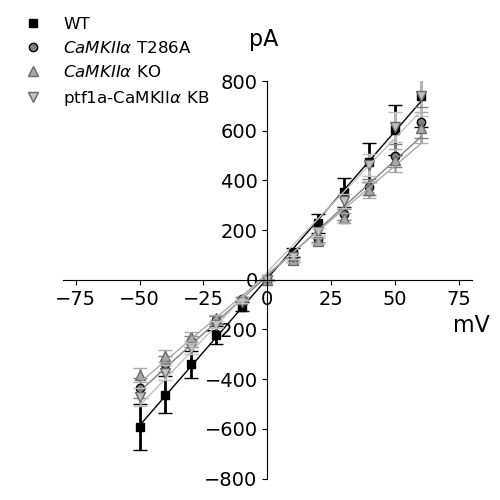

In [110]:
from scipy import stats

def iv_plot (fig, ax, x, y, y_err, counter, label):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        
    ax = plt.gca()  
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data',0))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data',0))
    
    # Plot the data
    ax.plot(x, y, ls = 'none', marker = markers[counter], color = colors[counter], label = x_labels[counter], 
            mec = edges[counter], markersize = sizes[counter]+2)  
    ax.errorbar(x, y, y_err, ls = 'none', elinewidth = 2, capsize = 5, color = colors[counter])
    line = [i * slope + intercept for i in x]
    ax.plot (x, line, lw = 1, color = colors[counter])      
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, frameon = False, loc='upper left', bbox_to_anchor=(-.15, 1.2), shadow=True, fontsize = 12)
    ax.set_xlim (-80, 80)
    ax.set_ylim(-800,800)
    ax.set_title("pA \n", fontsize = 16)
    ax.set_xlabel("mV", fontsize = 16, position = (1,1))
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()
    fig.savefig('camk_iv.jpg', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', format = 'jpg')

# Initiate the figure
fig, ax = plt.subplots(figsize=(6, 6), dpi = 100)    
vm = [-50,-40,-30, -20, -10, 0, 10, 20, 30, 40, 50, 60]

i = 0
for label in x:
    y = [float(df_mean.h_50[df_mean.strain == label]), 
        float(df_mean.h_40[df_mean.strain == label]), 
        float(df_mean.h_30[df_mean.strain == label]), 
        float(df_mean.h_20[df_mean.strain == label]), 
        float(df_mean.h_10[df_mean.strain == label]), 
        float(df_mean.h_0[df_mean.strain == label]), 
        float(df_mean.d_10[df_mean.strain == label]), 
        float(df_mean.d_20[df_mean.strain == label]), 
        float(df_mean.d_30[df_mean.strain == label]), 
        float(df_mean.d_40[df_mean.strain == label]), 
        float(df_mean.d_50[df_mean.strain == label]), 
        float(df_mean.d_60[df_mean.strain == label])]
    y_err = [float(df_ste.h_50[df_mean.strain == label]), 
        float(df_ste.h_40[df_ste.strain == label]), 
        float(df_ste.h_30[df_ste.strain == label]), 
        float(df_ste.h_20[df_ste.strain == label]), 
        float(df_ste.h_10[df_ste.strain == label]), 
        float(df_ste.h_0[df_ste.strain == label]), 
        float(df_ste.d_10[df_ste.strain == label]), 
        float(df_ste.d_20[df_ste.strain == label]), 
        float(df_ste.d_30[df_ste.strain == label]), 
        float(df_ste.d_40[df_ste.strain == label]), 
        float(df_ste.d_50[df_ste.strain == label]), 
        float(df_ste.d_60[df_ste.strain == label])]
    
    iv_plot(fig, ax, vm, y , y_err, i, label)
    i = i + 1

### Plot example traces

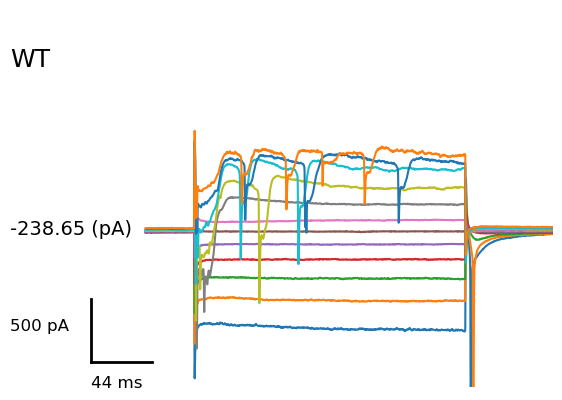

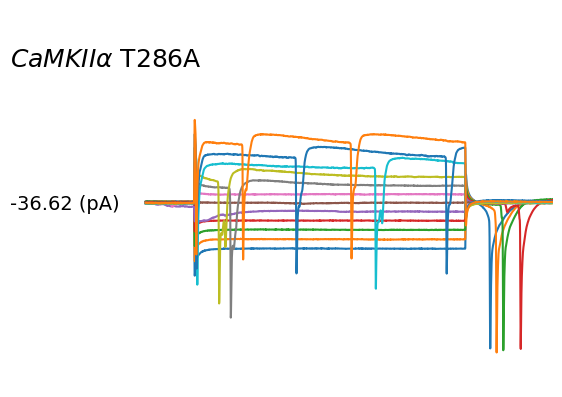

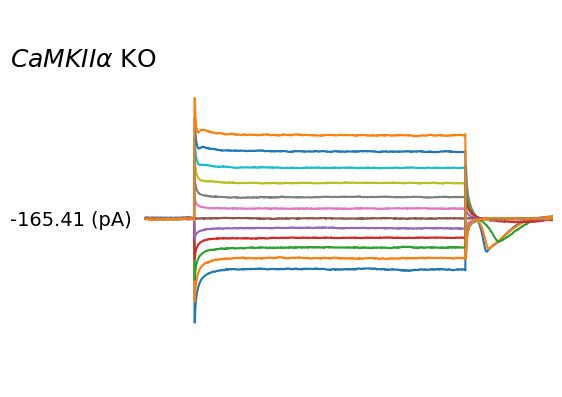

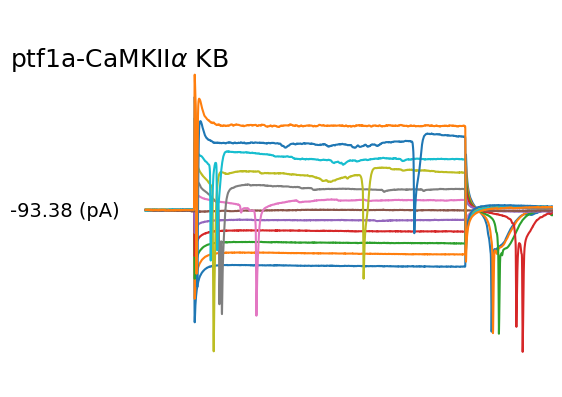

In [271]:
import pyabf

wt_trace = '2020_02_08_0000.abf'
camt_trace = '2019_08_01_0014.abf'
camko_trace = '2019_09_19_0010.abf'
camkb_trace = '2019_08_15_0008.abf'
traces = [wt_trace, camt_trace, camko_trace,camkb_trace]
channels = [0,0,0,2]

i = 0
for trace in traces:
    abf = pyabf.ABF(trace)
    sweep_list = abf.sweepList
    fig, ax = plt.subplots(figsize=(7, 5), dpi = 100) 
    if channels[i] == 0:
        start =30 * abf.dataPointsPerMs 
        end = 330  * abf.dataPointsPerMs
    elif channels[i] == 2:
        start = 480  * abf.dataPointsPerMs
        end = 780 * abf.dataPointsPerMs
    for sweep in sweep_list:
        abf.setSweep (sweepNumber = sweep, channel = channels[i])    
        ax.plot (abf.sweepX[start:end], abf.sweepY[start:end])
    y_max = 1500
    y_min = -1500
    ax.set_xlim(abf.sweepX[start]-0.1, abf.sweepX[end])
    y_tlen = (y_max-y_min)/6
    x_min,x_max = ax.get_xlim()
    x_tlen = (x_max - x_min)/9
    ax.annotate(x_labels[i], xy = (x_min, 1050), fontsize = 18)
    ax.annotate(str(round(abf.sweepY[start],2)) + ' (pA)', xy = (x_min, abf.sweepY[start]-50), fontsize = 14)
    
    # Plot scalebar
    if i == 0:
        ax.plot([x_min + 0.06, (x_min + x_tlen) + 0.06], [-1300,-1300], color = 'black', lw = 2)
        ax.annotate(str(int(x_tlen * 1000)) + ' ms', xy = ((x_min + 0.06), -1500), fontsize = 12)
        ax.plot([x_min + 0.06, x_min + 0.06], [-1300,-1300 + y_tlen], color = 'black', lw = 2)
        ax.annotate(str(int(y_tlen)) + ' pA', xy = (x_min , -1300 + (y_tlen/2)), fontsize = 12)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks([])
    ax.set_yticks([])
    i = i + 1
